In [3]:
import json
import gzip

from utils import download_url

#raw_url= "https://ml.materialsproject.org/projects/matbench_mp_is_metal.json.gz"
#raw_dir= "../data/matbench/mp_is_metal"
#download_url(raw_url, raw_dir)


json_filename = "../old_data/matbench/mp_e_form/matbench_mp_e_form.json.gz"


with gzip.open(json_filename, 'r') as fin:        # 4. gzip
    json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)

json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
data = json.loads(json_str) 


from pymatgen.core.structure import Structure


struct= Structure.from_dict(data["data"][0][0])

In [12]:
struct= Structure.from_dict(data["data"][100][0])


from pymatgen.util.coord import all_distances

all_distances(struct.cart_coords, struct.cart_coords), all_distances(struct.frac_coords, struct.frac_coords)

(array([[ 0.        , 16.31206896,  2.79059969,  7.90673782],
        [16.31206896,  0.        , 17.31558908, 20.0536725 ],
        [ 2.79059969, 17.31558908,  0.        ,  5.11613813],
        [ 7.90673782, 20.0536725 ,  5.11613813,  0.        ]]),
 array([[0.        , 1.51575597, 0.27272521, 0.77272521],
        [1.51575597, 0.        , 1.44027047, 1.43235953],
        [0.27272521, 1.44027047, 0.        , 0.5       ],
        [0.77272521, 1.43235953, 0.5       , 0.        ]]))

In [5]:
import pandas as pd
import torch
import json
import gzip
from pymatgen.core.structure import Structure


df = pd.read_csv("../old_data/freesolv/raw/freesolv.csv.gz",index_col=0, encoding="utf-8")
original_data = df.index
target = torch.tensor(df.values)

target.shape

torch.Size([642, 1])

In [3]:
#exppected behaviour when dealing with matbench dataset
complete_path = "../old_data/matbench/mp_is_metal/raw/matbench_mp_is_metal.json.gz"
with gzip.open(complete_path, 'r') as fin:        #  gzip
    json_bytes = fin.read()                      #  bytes (i.e. UTF-
json_str = json_bytes.decode('utf-8')            # string (i.e. JSON)
data = json.loads(json_str) 

original_data = [Structure.from_dict(data_list[0]) for data_list in data["data"]]
target = torch.tensor([data_list[1] for data_list in data["data"]])

NameError: name 'Structure' is not defined

In [6]:

original_data = [Structure.from_dict(data_list[0]) for data_list in data["data"]]
target = torch.tensor([data_list[1] for data_list in data["data"]])

KeyboardInterrupt: 

In [13]:
target = torch.tensor([data_list[1] for data_list in data["data"]]).view(-1,1)

In [14]:
target.shape

torch.Size([106113, 1])

In [ ]:
struct.atomic_numbers, struct.get_space_group_info(), struct.charge, struct.density, struct.distance_matrix

struct.as_dataframe()

## Matminer

In [ ]:


%matplotlib inline
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.structure import (SiteStatsFingerprint, StructuralHeterogeneity,
                                            ChemicalOrdering, StructureComposition, MaximumPackingEfficiency)
from matminer.featurizers.conversions import DictToObject
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

In [ ]:

featurizer = MultipleFeaturizer([
    SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint.from_preset("LocalPropertyDifference_ward-prb-2017"),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))
])

In [41]:
## creating small dataframe

structures = []
target=[]

for i in range(20):
    structures.append(Structure.from_dict(data["data"][i][0]))
    target.append(data["data"][i][1])
    
df= pd.DataFrame({"structure":structures, "target":target})

In [ ]:
df_features = featurizer.featurize_dataframe(df, col_id='structure')
feature_labels = featurizer.feature_labels()

In [ ]:
feature_labels

In [ ]:


dto = DictToObject(target_col_id='structure', overwrite_data=True)
data = dto.featurize_dataframe(df, 'structure')


In [ ]:
## featurizing one structure

%%time
print('Total number of features:', len(featurizer.featurize(data['structure'][0])))
print('Number of sites in structure:', len(data['structure'][0]))


In [ ]:


%%time
X = featurizer.featurize_many(data['structure'], ignore_errors=True)


# Site featurization

In [26]:
## site featurization



from matminer.featurizers.site import (
    AGNIFingerprints,
    AverageBondAngle,
    AverageBondLength,
    BondOrientationalParameter,
    ChemEnvSiteFingerprint,
    CoordinationNumber,
    CrystalNNFingerprint,
    GaussianSymmFunc,
    GeneralizedRadialDistributionFunction,
    LocalPropertyDifference,
    OPSiteFingerprint,
    VoronoiFingerprint,
)

from pymatgen.analysis.local_env import VoronoiNN

site_featurizers =[
                AGNIFingerprints(),
#                AverageBondAngle(VoronoiNN()),
#                AverageBondLength(VoronoiNN()),
#                BondOrientationalParameter(),
#                ChemEnvSiteFingerprint.from_preset("simple"),
#                CoordinationNumber(),
#                CrystalNNFingerprint.from_preset("ops"),
#                GaussianSymmFunc(),
#                GeneralizedRadialDistributionFunction.from_preset("gaussian"),
#                LocalPropertyDifference(),
#                OPSiteFingerprint(),
#                VoronoiFingerprint(),
]


In [27]:
from typing import Optional,Dict,Tuple

def featurize_site(df: pd.DataFrame, site_featurizers, aliases: Optional[Dict[str, str]] = None) -> pd.DataFrame:
        """Decorate input `pandas.DataFrame` of structures with site
        features, specified by the MODFeaturizer preset.
        Arguments:
            df: the input dataframe with a `"structure"` column
                containing `pymatgen.Structure` objects.
            aliases: optional dictionary to map matminer output column
                names to new aliases, mostly used for
                backwards-compatibility.
        Returns:
            pandas.DataFrame: the decorated DataFrame.
        """

        df = df.copy()
        df.columns = ["Input data|" + x for x in df.columns]
        
        site_stats: Tuple[str] = ("mean", "std_dev")

        for fingerprint in site_featurizers:
            #site_stats_fingerprint = SiteStatsFingerprint(
            #    fingerprint, stats= site_stats
            #)
            
            df = fingerprint.featurize_dataframe(
                df, "Input data|structure", multiindex=False, ignore_errors=True
            )

            fingerprint_name = fingerprint.__class__.__name__
            if aliases:
                fingerprint_name = aliases.get(fingerprint_name, fingerprint_name)
            if "|" not in fingerprint_name:
                fingerprint_name += "|"
            df.columns = [
                f"{fingerprint_name}{x}" if "|" not in x else x for x in df.columns
            ]

        return df

In [28]:
site_df = featurize_site(df=df,site_featurizers=site_featurizers)

AGNIFingerprints:   0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
fingerprint = VoronoiFingerprint()

## consistent length 32 feature

fingers = []

for i in df.index:
    struct = df["structure"][i]
    for j in range(len(struct)):
        finger = fingerprint.featurize(struct=struct, idx=j)
        fingers.append(finger)
        
fingers = np.array(fingers)

fingerprint.feature_labels()

['Voro_index_3',
 'Voro_index_4',
 'Voro_index_5',
 'Voro_index_6',
 'Voro_index_7',
 'Voro_index_8',
 'Voro_index_9',
 'Voro_index_10',
 'Symmetry_index_3',
 'Symmetry_index_4',
 'Symmetry_index_5',
 'Symmetry_index_6',
 'Symmetry_index_7',
 'Symmetry_index_8',
 'Symmetry_index_9',
 'Symmetry_index_10',
 'Voro_vol_sum',
 'Voro_area_sum',
 'Voro_vol_mean',
 'Voro_vol_std_dev',
 'Voro_vol_minimum',
 'Voro_vol_maximum',
 'Voro_area_mean',
 'Voro_area_std_dev',
 'Voro_area_minimum',
 'Voro_area_maximum',
 'Voro_dist_mean',
 'Voro_dist_std_dev',
 'Voro_dist_minimum',
 'Voro_dist_maximum']

/home/harold/miniconda3/envs/chem/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/harold/miniconda3/envs/chem/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0.1044766460688916

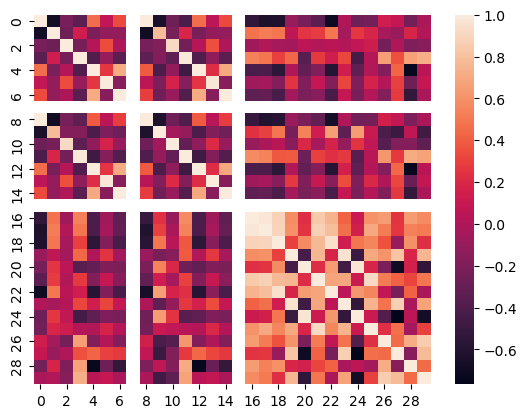

In [61]:
import seaborn as sns

#voronoi features are not too correlated

sns.heatmap(np.corrcoef(fingers.T))

np.nanmean(np.corrcoef(fingers.T))